# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data.set_index('Date', inplace=True)

<Axes: title={'center': 'Close Prices Over Time'}, xlabel='Date'>

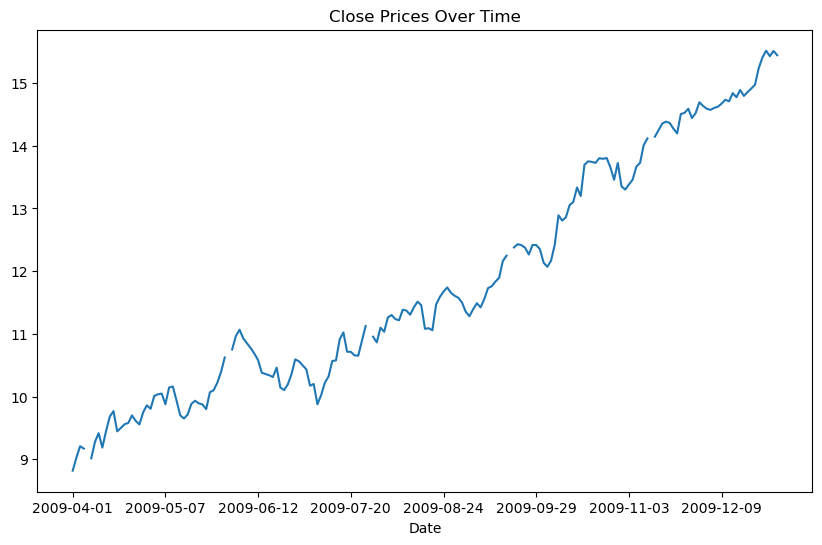

In [5]:
# Plot the Close Data
data['Close'].plot(figsize=(10, 6), title='Close Prices Over Time')

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
print(data.isnull().sum())

Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
# forward fill missing values
data.ffill(inplace=True)

In [8]:
# Check for null values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<Axes: title={'center': 'Cleaned Close Prices Over Time'}, xlabel='Date'>

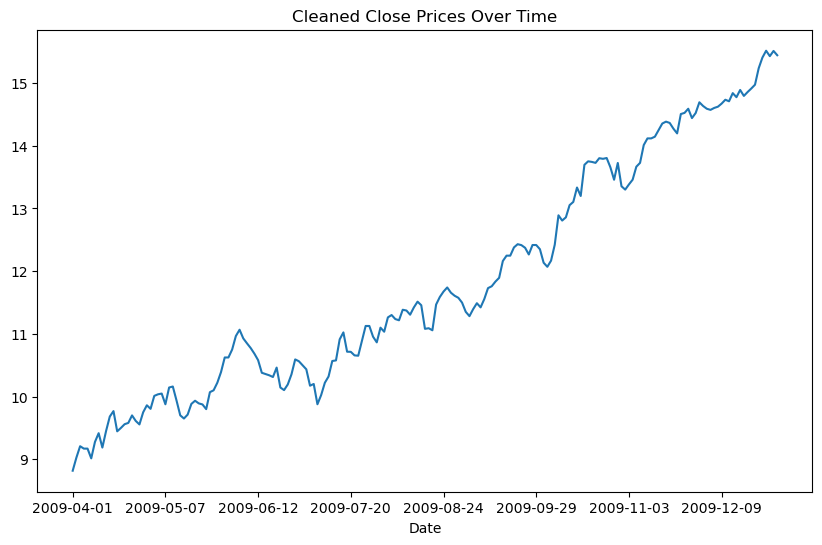

In [9]:
# Plot the cleaned Close Data
data['Close'].plot(figsize=(10, 6), title='Cleaned Close Prices Over Time')

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['20_day_MA'] = data['Close'].rolling(window=20).mean()
data['20_day_STD'] = data['Close'].rolling(window=20).std()
data['Upper_BB'] = data['20_day_MA'] + (2 * data['20_day_STD'])
data['Lower_BB'] = data['20_day_MA'] - (2 * data['20_day_STD'])

In [11]:
# Remove rows with NaN bollinger bands
data.dropna(inplace=True)

In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper_BB', 'Lower_BB']]

In [13]:
# Display as Dataframe
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,20_day_MA,20_day_STD,Upper_BB,Lower_BB
Date,,,,,,,,,,
2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898
2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.614014,0.275700,10.165415,9.062614
2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.657115,0.242734,10.142584,9.171646
2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,9.700490,0.248804,10.198098,9.202882
2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,9.737688,0.259638,10.256965,9.218412


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

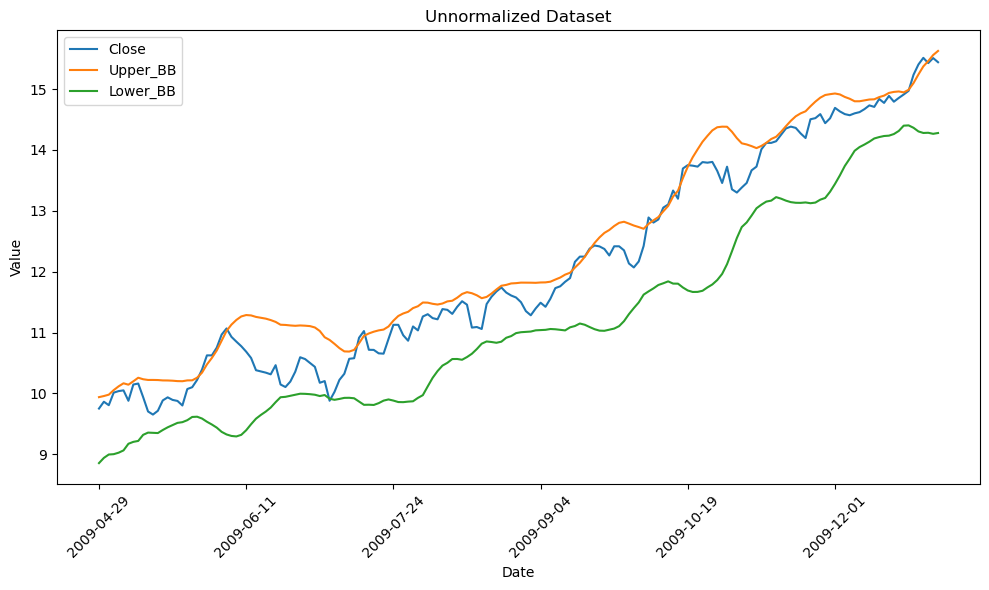

Unnormalized Dataset:


,Close,Upper_BB,Lower_BB
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


In [14]:
# Display & Plot Un-normalized Dataset
plt.figure(figsize=(10, 6))
for col in dataset.columns:
    plt.plot(dataset.index, dataset[col], label=col)

plt.title('Unnormalized Dataset')
plt.xlabel('Date')
plt.ylabel('Value')

plt.xticks(
    dataset.index[::30],  
    rotation=45  
)

plt.legend()
plt.tight_layout()  
plt.show()

print("Unnormalized Dataset:")
display(dataset.head(15))

In [15]:
# # Normalize Dataset with StandardScaler
normlist = []

normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()  
    column_data = dataset[[col]]  
    normed_data = normalizer.fit_transform(column_data)
    normed_dataset[col] = normed_data.flatten()  
    normlist.append(normalizer)

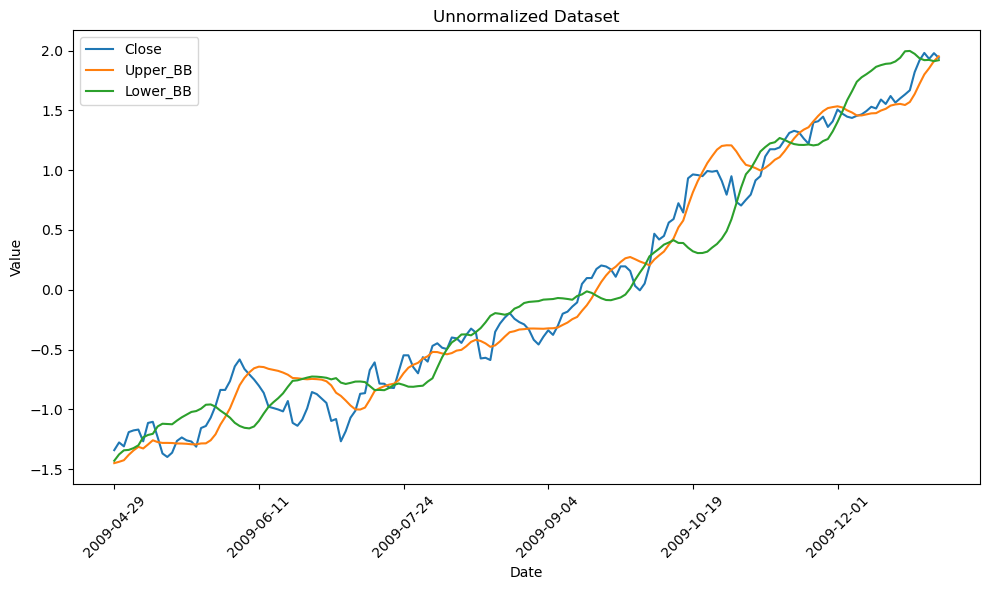

Normalized Dataset:


,Close,Upper_BB,Lower_BB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


In [16]:
# Display & Plot Normalized Dataset
plt.figure(figsize=(10, 6))
for col in normed_dataset.columns:
    plt.plot(normed_dataset.index, normed_dataset[col], label=col)

plt.title('Unnormalized Dataset')
plt.xlabel('Date')
plt.ylabel('Value')

plt.xticks(
    normed_dataset.index[::30],  
    rotation=45  
)

plt.legend()
plt.tight_layout()  
plt.show()

print("Normalized Dataset:")
display(normed_dataset.head(15))

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [17]:
# split dataset df into train (50%) and test (50%) datasets
split_index = len(normed_dataset) // 2
train_df = normed_dataset.iloc[:split_index]
test_df = normed_dataset.iloc[split_index:]

In [18]:
# display train and test dfs (ensure no overlap)
print("Training Dataset:")
display(train_df.tail(5))

print("Testing Dataset:")
display(test_df.head(5))

Training Dataset:


,Close,Upper_BB,Lower_BB
Date,,,
2009-08-24,-0.232468,-0.391810,-0.209008
2009-08-25,-0.194561,-0.355389,-0.198131
2009-08-26,-0.242949,-0.346786,-0.158160
2009-08-27,-0.270805,-0.332632,-0.141364
2009-08-28,-0.289614,-0.329695,-0.111016


Testing Dataset:


,Close,Upper_BB,Lower_BB
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844


In [19]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# track index to remember which feature is which
idx_close = train_df.columns.get_loc('Close')      
idx_bb_upper = train_df.columns.get_loc('Upper_BB')  
idx_bb_lower = train_df.columns.get_loc('Lower_BB')  

print(f"Index of Close: {idx_close}")
print(f"Index of Upper_BB: {idx_bb_upper}")
print(f"Index of Lower_BB: {idx_bb_lower}")

Shape of X_train: (86, 3)
Shape of X_test: (86, 3)
Index of Close: 0
Index of Upper_BB: 1
Index of Lower_BB: 2


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [20]:
@keras.saving.register_keras_serializable()

class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        self.model = Sequential([
            Input(shape=(self.state_size,)),  
            Dense(64, activation='relu'),    
            Dense(32, activation='relu'),    
            Dense(8, activation='relu'),     
            Dense(self.action_size, activation='linear')  
        ])
        
        self.model.compile(
            loss='mse',  
            optimizer=Adam(learning_rate=0.001)  
        )

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [21]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''): # Este é o método inicializador da classe. Ele configura os parâmetros e variáveis do agente.
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95 # Fator de desconto. Valores entre 0 e 1. Determina o quanto o agente valoriza recompensas futuras em comparação às imediatas. Exemplo: 0.95 significa que recompensas futuras valem um pouco menos do que recompensas imediatas.
        self.epsilon = 1.0 # Taxa de exploração. Inicialmente alta (1.0), o agente escolhe ações aleatórias para explorar o ambiente.
        self.epsilon_min = 0.01 # O valor mínimo da taxa de exploração (evita 100% de decisões previsíveis)
        self.epsilon_decay = 0.995 # Controla o quanto a taxa de exploração diminui com o tempo
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()


    # Deep Q Learning (DQL) model
    # state_size: Tamanho da entrada da rede (número de informações sobre o estado atual).
    # action_size: Número de saídas, correspondente às ações possíveis (manter, comprar, vender).
    # DQN: Uma rede neural básica com três camadas (definida em outro lugar no código).
    def _model(self): # Constrói o modelo de rede neural para o agente.
        model = DQN(self.state_size, self.action_size).model
        return model
    

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state): # Este método prevê os valores Q para um dado estado. Valores Q representam a "qualidade" de cada ação.
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            # print("return: ",random.randrange(self.action_size))   
            return random.randrange(self.action_size)   
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        options = self.get_q_values_for_state(state)
        # print("options: ", options)
        return np.argmax(options[0]) 

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)  
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # define epsilon decay (for the act function)     
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [22]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()
    
def get_state(data, t, n):    
    d = t - n
    if d >= 0:
        block = data[d:t] 
    else:
        block =  np.array([data[0]]*n) 
    res = []
    for i in range(n - 1):
        feature_res = []
        for feature in range(data.shape[1]):
            feature_res.append(sigmoid(block[i + 1, feature] - block[i, feature]))
        res.append(feature_res)
    # display(res)
    return np.array([res])
    
# def get_state(data, t, n):
#     # Garantir que `data` é um array NumPy
#     data = np.array(data)
#     # print("data: ",data)

#     # Determinar o bloco de dados a ser usado
#     d = t - n
#     # print("d: ",d)

#     if d >= 0:
#         block = data[d:t]
#     else:
#         block = np.vstack([data[0]] * (abs(d)) + [data[0:t]])  # Repetir o primeiro valor se não houver histórico suficiente

#     # print("block: ",block)

#     # Calcular as diferenças (deltas) entre dias consecutivos
#     deltas = block[1:] - block[:-1]
#     # print("deltas: ",deltas)

#     # Aplicar a função sigmoide nos deltas
#     res = 1 / (1 + np.exp(-deltas))  # Vetorizando a aplicação da função sigmoide
#     # print("res: ",res)

#     # Expandir a dimensão para manter o formato esperado
#     return np.expand_dims(res, axis=0)

# # returns an an n-day state representation ending at time t
# def get_state(data, t, window_size):
#     d = t - window_size + 1
#     block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
#     res = []
#     for i in range(len(block) - 1):
#         feature_res = []
#         for feature in range(data.shape[1]):
#             feature_res.append(sigmoid(block[i + 1][feature] - block[i][feature]))
#         res.append(feature_res)
#     return np.array(res).reshape(1, -1)

### Training Loop

In [23]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
print("Shape of Training Data:", X_train.shape)

Shape of Training Data: (86, 3)


In [24]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1
num_features = X_train.shape[1] 
print("num_features:", num_features)

agent = Agent(window_size=window_size, num_features=X_train.shape[1], test_mode=False, model_name="")

num_features: 3


Running episode 0/1:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $10.01
Sell: $10.05 | Profit: $0.04
Buy: $10.16
Sell: $9.94 | Profit: -$0.22
Buy: $9.71
Buy: $9.93
Buy: $9.89
Buy: $9.88
Sell: $10.07 | Profit: $0.36
Buy: $10.10
Buy: $10.22
Sell: $10.39 | Profit: $0.46
Buy: $10.62
Sell: $10.62 | Profit: $0.73
Sell: $10.75 | Profit: $0.88
Buy: $10.97
Buy: $10.93
Sell: $10.85 | Profit: $0.75
Sell: $10.58 | Profit: $0.36
Sell: $10.38 | Profit: -$0.24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steppSell: $10.36 | Profit: -$0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepSell: $10.34 | Profit: -$0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepBuy: $10.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepSell: $10.46 | Profit: $0.15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepBuy: $10.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/stepSell: $10.56 | Profit: $0.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/stepBuy: $10.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepBuy: $10.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepSell: $10.17 | Profit: -$0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepBuy: $10.20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

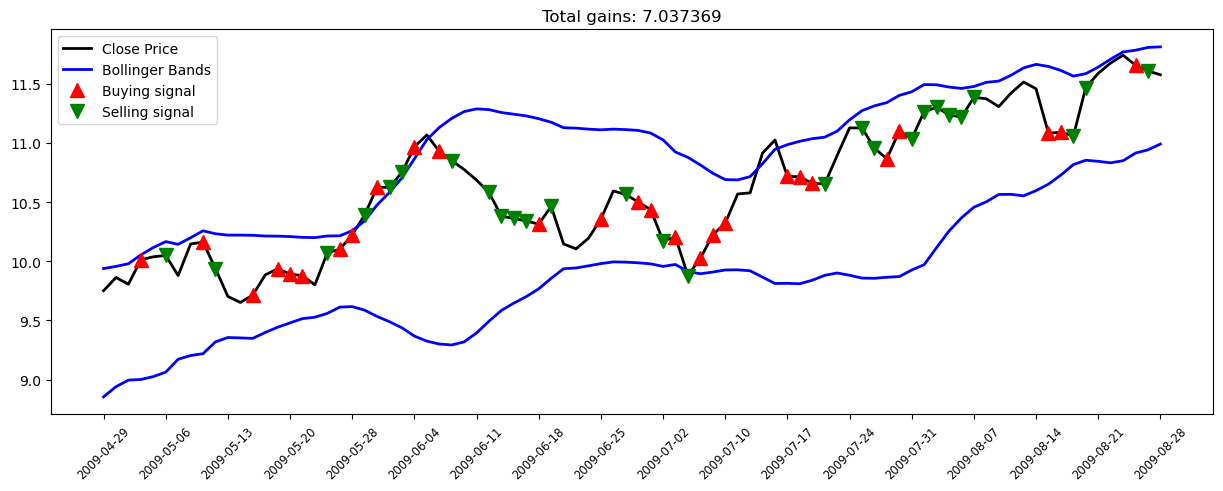

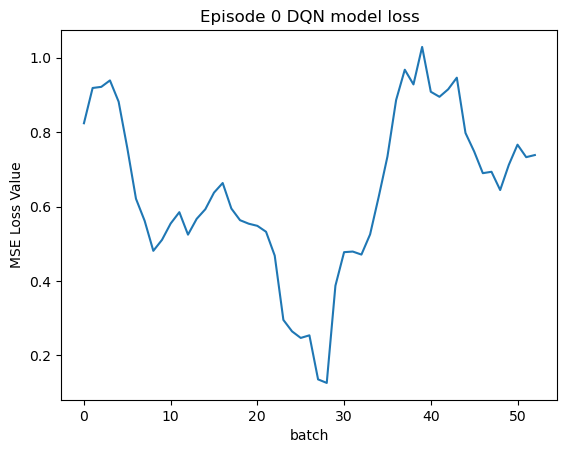

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [25]:
keras.config.disable_traceback_filtering()  

l = X_train.shape[0]  

batch_size = 32

episode_count = 1

normalizer_close = normlist[0] 
normalizer_bb_upper = normlist[1]  
normalizer_bb_lower = normlist[2]  

X_train_true_price = normalizer_close.inverse_transform(X_train[:, [idx_close]])  
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, [idx_bb_upper]])  
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, [idx_bb_lower]])

batch_losses = []  
num_batches_trained = 0 

for e in range(episode_count):
    state = get_state(X_train, 0, window_size)  

    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)  
        next_state = get_state(X_train, t + 1, window_size + 1)  

        # initialize reward for the current time step
        reward = 0

        if action == 1: # buy
            buy_price = X_train_true_price[t, 0]  
            agent.inventory.append(buy_price)  
            states_buy.append(t)  
            print(f'Buy: {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0: # sell
            # get the bought price of the stock you are selling (i.e. the stock at the beginning of the inventory)
            bought_price = agent.inventory.pop(0)  
            sell_price = X_train_true_price[t, 0]  
            trade_profit = sell_price - bought_price  
            reward = max(trade_profit, 0)  
            total_profit += trade_profit  
            
            if trade_profit >= 0:
                total_winners += trade_profit  
            else:
                total_losers += trade_profit  
                
            states_sell.append(t)  
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        
        if len(agent.memory) > batch_size:
            losses = agent.exp_replay(batch_size)  
            batch_losses.append(sum(losses))  
            
    if e % 2 == 0:
        # save the model every 2 episodes (in case of crash or better training iteration in the middle of training process)
        agent.model.save(f'model_ep{e}.keras')

### Plot Training Loss

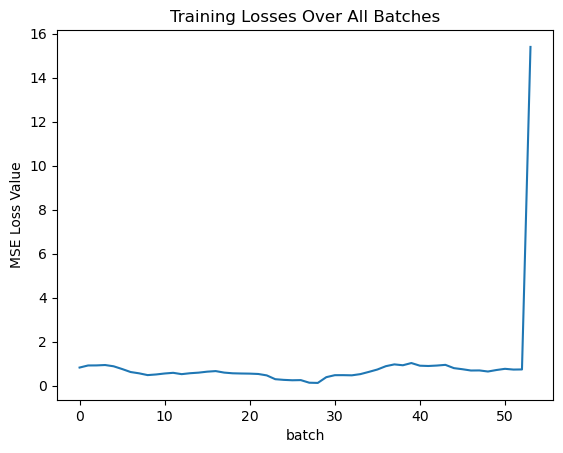

In [26]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "Training Losses Over All Batches")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [27]:
# Define Parameters
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)  # Primeiro estado do conjunto de teste
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(
    window_size=window_size,
    num_features=X_test.shape[1],
    test_mode=True,
    model_name=f'model_ep{episode_count - 1}.keras'  # Carrega o modelo do último episódio treinado
)
agent.inventory = []

# Valores reais para plotagem
X_test_true_price = normalizer_close.inverse_transform(X_test[:, [idx_close]])  # Preço real (Close)
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, [idx_bb_upper]])  # Upper BB
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, [idx_bb_lower]])  # Lower BB

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step------------------------------------------
Total Profit: $0.00
------------------------------------------


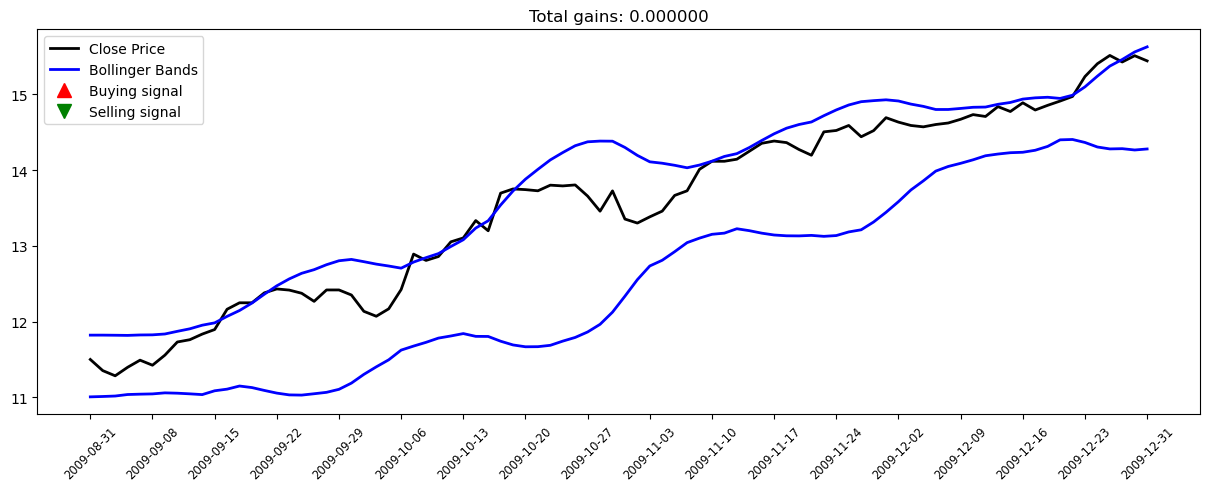

In [28]:
state = get_state(X_test, 0, window_size + 1)  # Inicializando o estado com os primeiros valores do conjunto de teste

for t in range(l_test):
    action = agent.act(state)  # Obter a ação do agente
    next_state = get_state(X_test, t + 1, window_size + 1)  # Obter o próximo estado
    reward = 0

    # Processar ações de compra e venda
    if action == 1:  # Buy
        buy_price = X_test_true_price[t, 0]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')
    elif action == 2 and len(agent.inventory) > 0:  # Sell
        bought_price = agent.inventory.pop(0)
        sell_price = X_test_true_price[t, 0]
        trade_profit = sell_price - bought_price
        reward = max(trade_profit, 0)
        total_profit += trade_profit
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

    if t == l_test - 1:
        done = True

    # Verificar estado vazio
    if next_state.size == 0:
        raise ValueError(f"next_state está vazio na iteração {t}. Verifique a função get_state.")

    # Atualizar o estado
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)
